# ColPali: Generate your own similarity maps 👀

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/gen_colpali_similarity_maps.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1846870432831402315)

## Introduction

With our new model *ColPali*, we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. By feeding the ViT output patches from PaliGemma-3B to a linear projection, we create a multi-vector representation of documents. We train the model to maximize the similarity between these document embeddings and the query embeddings, following the ColBERT method.

Using ColPali removes the need for potentially complex and brittle layout recognition and OCR pipelines with a single model that can take into account both the textual and visual content (layout, charts, ...) of a document.

ColPali is also highly interpretable: similarity maps can be obtained between patches and query tokens. These maps highlight ColPali’s strong OCR capabilities and chart understanding.

![Similarity map examples](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/interpretability/similarity_maps.jpeg?raw=true)

The following notebook guide you through how to generate your own similarity maps.

## Hardware Requirements

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on a M2 Pro Mac).


## Login to a HuggingFace account

Because ColPali uses the PaliGemma (Gemma-licensed) as its VLM backbone, you will have to login to a HuggingFace account that has accepted the terms and conditions of [`google/paligemma-3b-mix-448`](https://huggingface.co/google/paligemma-3b-mix-448).

In [ ]:
!pip install -q -U huggingface_hub
from huggingface_hub import login

login()

## Imports

This notebook leverages [`colpali-engine`](https://github.com/illuin-tech/colpali), the official implementation of ColPali. This package also contains the training code (processor, collator, trainer...) for fine-tuning ColPali on your own dataset.

Make sure you install the `colpali-engine[interpretability]` optional dependencies!

In [ ]:
!pip install -q -U "colpali-engine[interpretability]>=0.3.2,<0.4.0"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 109.5 MB/s eta 0:00:00


In [ ]:
import pprint
from io import BytesIO
from pathlib import Path
from typing import Optional, cast

import matplotlib.pyplot as plt
import requests
import torch
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from PIL import Image

## A few custom utils

In [ ]:
def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

## Load ColPali

Click on the following link to open the model card for [`vidore/colpali-v1.2`](https://huggingface.co/vidore/colpali-v1.2).

In [ ]:
model_name = "vidore/colpali-v1.2"

device = get_torch_device("auto")
print(f"Using device: {device}")

# Load the model
model = cast(
    ColPali,
    ColPali.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# Load the processor
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(model_name))

Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

## Load image and query inputs

Run the following cell to load the default query and image inputs. If you want to use your own image/query, upload your image in the Google Colab environment, then replace the following variable values with your own.

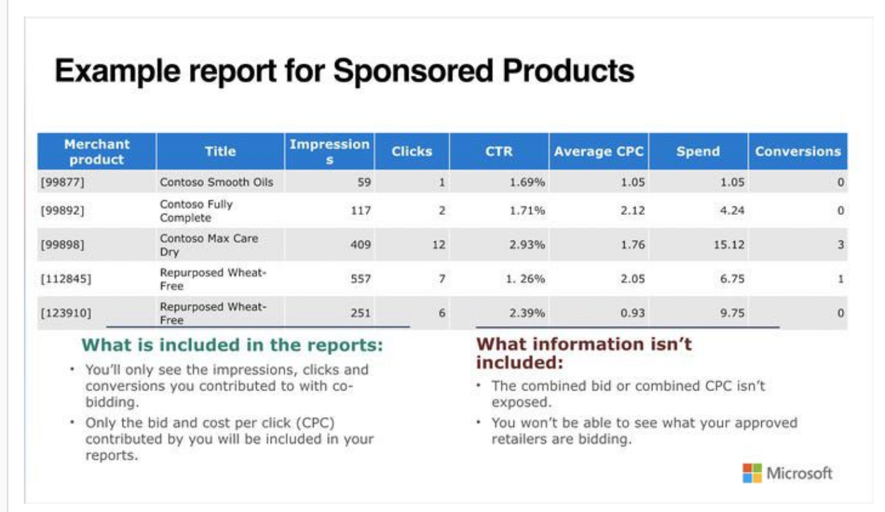

In [ ]:
# ==========================     USER INPUTS     ==========================

image_filepath: Optional[str] = "colp2.png"
query: str = "What is the average cpc of contoso fully complete and repurposed wheat-free?"

# =========================================================================

if image_filepath:
    assert Path(image_filepath).is_file(), f"Cannot find the image file at `{image_filepath}`"
    image = Image.open(image_filepath)
else:
    image = load_image_from_url(
        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/shift_kazakhstan.jpg?raw=true"
    )

# Preview the image
scale_image(image, 512)

## Preprocess and embed the query and the image

In [ ]:
# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

## Get the per-token similarity maps

First step is to compute all the similarity scores between the query tokens and the image patches. Then, we reshape the resulting tensor to make the image structure appear clearly in the tensor shape.

In [ ]:
# Get the number of image patches
n_patches = processor.get_n_patches(image_size=image.size, patch_size=model.patch_size)

print(f"Number of image patches: {n_patches}")

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)

Number of image patches: (32, 32)


In [ ]:
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask,
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

Similarity map shape: (query_length, n_patches_x, n_patches_y) = (32, 32, 32)


The following cell will display the tokens of the query. For clarity, we will ask the user to select the token for which they want to visualize the similarity map.

In [ ]:
# Use this cell output to choose a token using its index
query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Query',
 2: ':',
 3: '▁What',
 4: '▁is',
 5: '▁the',
 6: '▁average',
 7: '▁c',
 8: 'pc',
 9: '▁of',
 10: '▁conto',
 11: 'so',
 12: '▁fully',
 13: '▁complete',
 14: '▁and',
 15: '▁repur',
 16: 'posed',
 17: '▁wheat',
 18: '-',
 19: 'free',
 20: '?'}


## Select the query token of interest

In [ ]:
# Choose a token using its index
token_idx = 17  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

Selected token: `▁wheat`


## Visualize the similarity map for the current query token

The brighter the patch, the higher similarity score it has with the selected token. This similarity map exhibits OCR capabilities and chart understanding of ColPali. For instance, the patch containing the selected query token should be clearly highlighted in the similarity map.

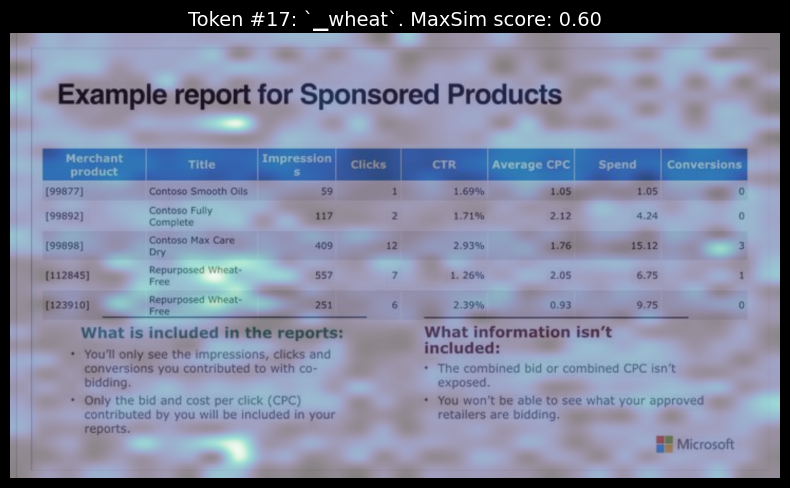

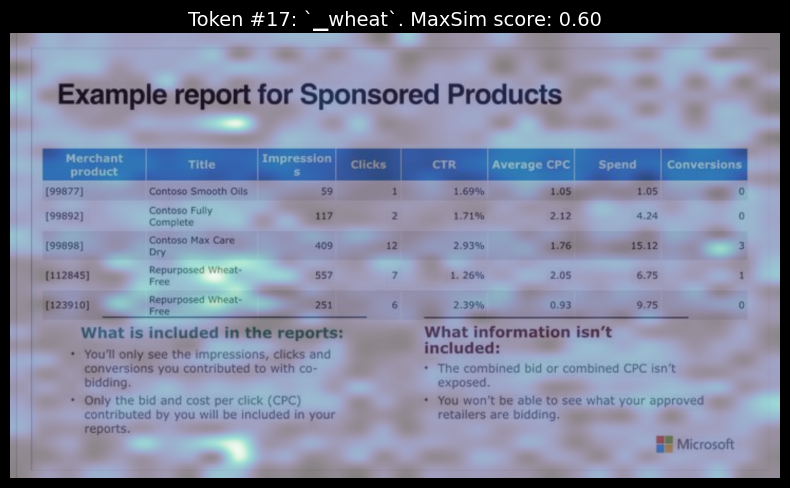

In [ ]:
fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

**Additional note:** You should notice a few white patches with high similarity scores. This behavior might first seem surprising as the white patches should not carry a meaningful signal from the original images. We believe the vectors associated with these patches share a similar role with the ViT registers [(Darcet et al., 2023)](https://doi.org/10.48550/arXiv.2309.16588), i.e. these patches were repurposed for internal computations and stored the global information from the whole image.

## Bonus: Generate similarity maps for all query tokens

You can use the higher-level function `generate_similarity_maps` to generate similarity maps for all query tokens.

In [ ]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")

Similarity map for token `<bos>` saved at `similarity_map_0.png`
Similarity map for token `Query` saved at `similarity_map_1.png`
Similarity map for token `:` saved at `similarity_map_2.png`
Similarity map for token `▁How` saved at `similarity_map_3.png`
Similarity map for token `▁is` saved at `similarity_map_4.png`
Similarity map for token `▁introducing` saved at `similarity_map_5.png`
Similarity map for token `▁Sponsored` saved at `similarity_map_6.png`
Similarity map for token `▁Products` saved at `similarity_map_7.png`
Similarity map for token `▁improving` saved at `similarity_map_8.png`
Similarity map for token `▁product` saved at `similarity_map_9.png`
Similarity map for token `▁visibility` saved at `similarity_map_10.png`
Similarity map for token `?` saved at `similarity_map_11.png`
